# Dogs vs Cats Redux vgg

In [1]:
%pwd

u'/home/ubuntu/courses/deeplearning1/nbs/lesson1'

In [2]:
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

In [3]:
# current dir to search path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# import modules
from utils import *
from vgg16 import Vgg16

%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


## Create validation set and sample

In [11]:
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/courses/deeplearning1/nbs/lesson1/data


In [12]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/train


randomly select validation data and move to data/valid

In [14]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000):
    os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

randomly select sample data for prototyping and copy

In [15]:
from shutil import copyfile
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200):
    copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

randomly select sample validation data for prototyping and copy

In [16]:
%cd $DATA_HOME_DIR/valid

/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/valid


In [19]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50):
    copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Organize images into category folders

In [21]:
%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/sample/train
mkdir: cannot create directory 'cats': File exists
mkdir: cannot create directory 'dogs': File exists
/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/sample/valid
mkdir: cannot create directory 'cats': File exists
mkdir: cannot create directory 'dogs': File exists
/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/valid
mkdir: cannot create directory 'cats': File exists
mkdir: cannot create directory 'dogs': File exists
/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/train
mkdir: cannot create directory 'cats': File exists
mkdir: cannot create directory 'dogs': File exists


In [22]:
# create an 'unknown' class for test
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/test


## Finetuning and training

In [4]:
%cd $DATA_HOME_DIR

# Set up paths
#path = DATA_HOME_DIR + '/'
path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/'
results_path = DATA_HOME_DIR + '/results/'
train_path = DATA_HOME_DIR + '/train/'
valid_path = DATA_HOME_DIR + '/valid/'

/home/ubuntu/courses/deeplearning1/nbs/lesson1/data


In [5]:
# import helper class
vgg = Vgg16()

In [8]:
# set constants
batch_size = 64
num_epochs = 3 # what is this for?

In [26]:
# fine tune
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

# i'm guessing this is the learning rate
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [27]:
# fit over a few epochs
latest_weights_filename = None
for epoch in range(num_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
    
print "Completed %s fit operations" % num_epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 642s - loss: 0.3769 - acc: 0.9690 - val_loss: 0.2448 - val_acc: 0.9815
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 643s - loss: 0.3400 - acc: 0.9753 - val_loss: 0.2461 - val_acc: 0.9825
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 642s - loss: 0.3476 - acc: 0.9754 - val_loss: 0.1726 - val_acc: 0.9885
Completed 3 fit operations


### Questions
- what do the epochs represent? 
- does each epoch use all the data in batches?

## Predictions

In [30]:
batches, preds = vgg.test(test_path, batch_size=batch_size*2)

Found 12500 images belonging to 1 classes.


In [33]:
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.0000e+00   0.0000e+00]
 [  1.0000e+00   3.7372e-33]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  0.0000e+00   1.0000e+00]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


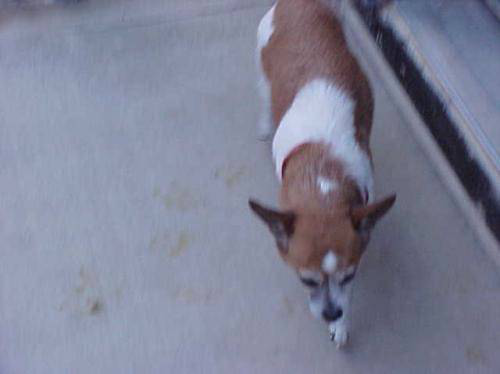

In [41]:
# verify classification
from PIL import Image
Image.open(test_path + filenames[1])
#batches.classes[1]

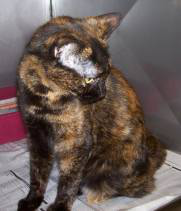

In [40]:
Image.open(test_path + filenames[2])
#batches.classes[2]

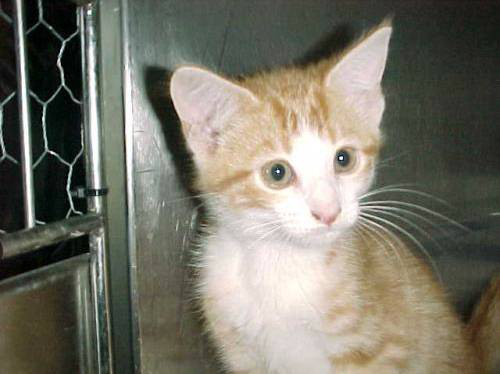

In [37]:
Image.open(test_path + filenames[3])

In [42]:
# save result arrays for later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

In [6]:
latest_weights_filename = 'ft2.h5'
vgg.model.load_weights(results_path + latest_weights_filename)

In [9]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [10]:
filenames = val_batches.filenames
expected_labels = val_batches.classes # 0 or 1

# round predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

### Questions
- what is the probs[:,0] syntax mean?
first column i think

In [11]:
from keras.preprocessing import image

# create helper function to plot images by indix in the validation set
def plots_idx(idx, titles=None):
    # plots is a helper function in utils.py
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
# number of images per view
n_view = 4

### 1. A few correct labels at random

Found 1973 correct labels


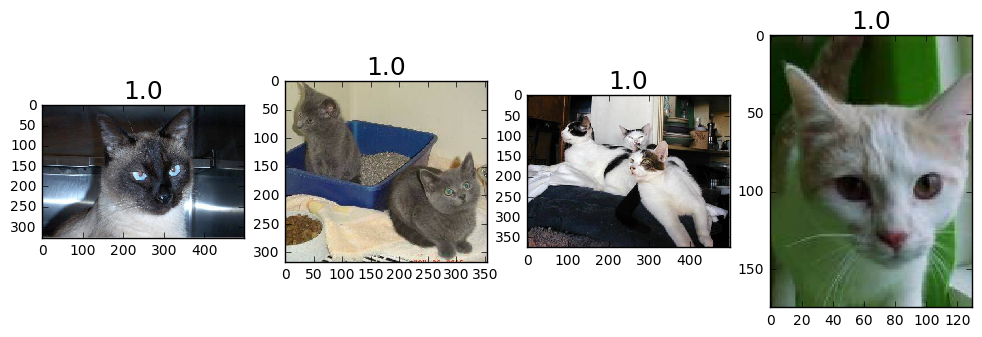

In [12]:
correct = np.where(our_labels==expected_labels)[0]
# why the [0] at the end?
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

### 2. A few incorrect labels at random

Found 27 incorrect labels


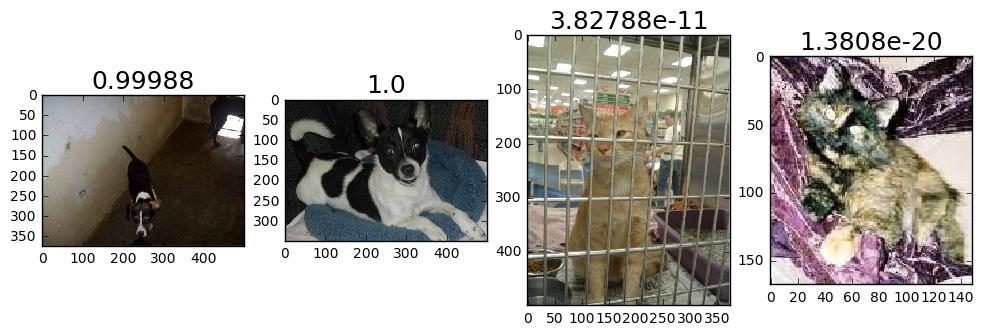

In [13]:
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

### 3a. Correct cat images with high confidence

Found 989 confident correct cats


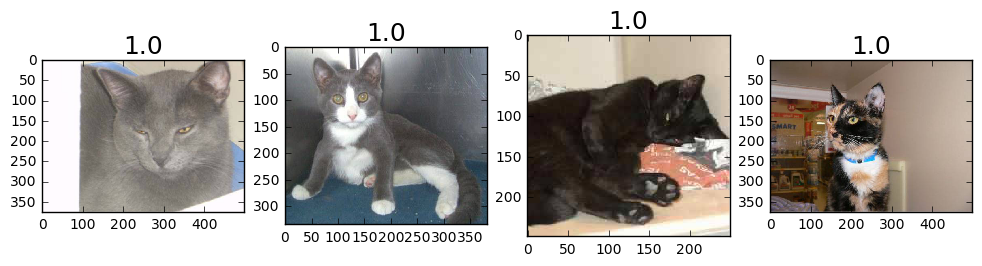

In [14]:
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

### 3b. Correct dog images with high confidence

Found 984 confident correct dogs


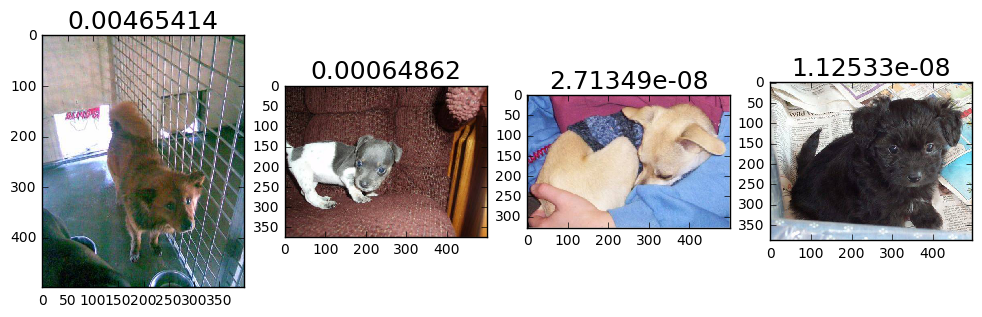

In [15]:
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[::-1][:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

### 4a. Incorrect cat images with high confidence

Found 14 incorrect cats


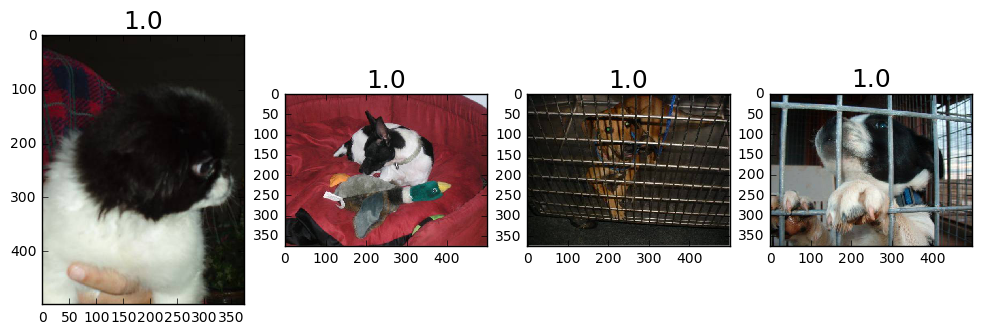

In [16]:
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)

if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

### 4b. Incorrect dog images with high confidence

Found 13 incorrect dogs


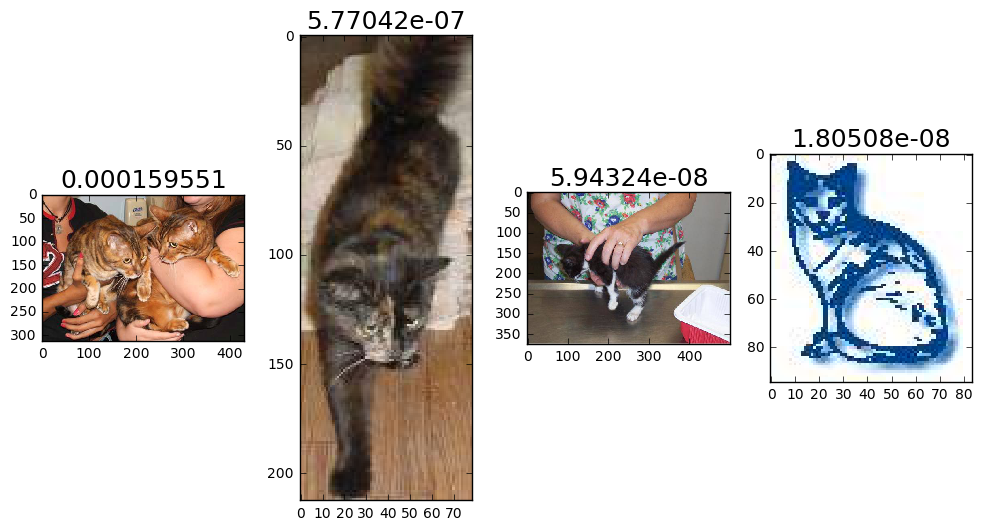

In [17]:
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)

if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[::-1][:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

### 5. The most uncertain labels (i.e. prob closest to 0.5)

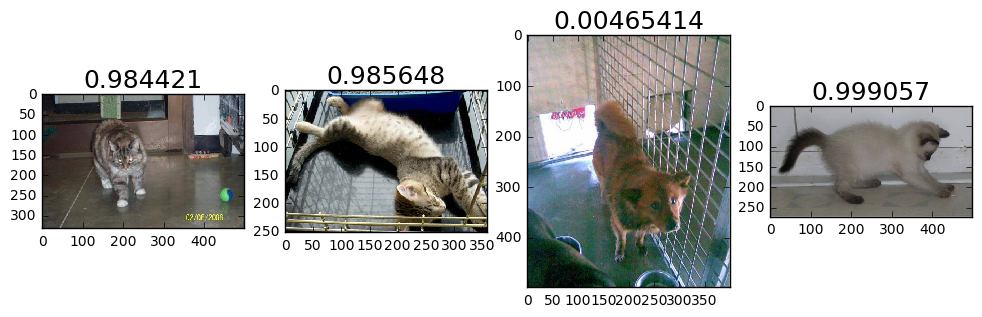

In [20]:
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

### Confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[989  13]
 [ 14 984]]


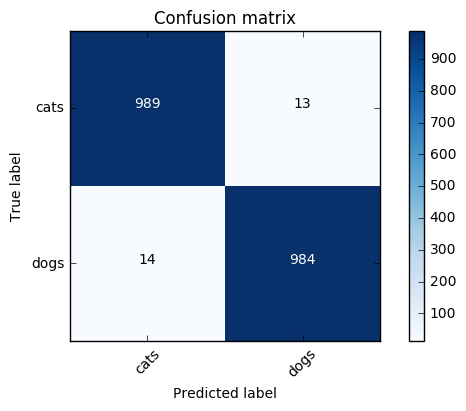

In [22]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit predictions to Kaggle

In [31]:
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [32]:
# grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) & (isdog == 0)])

Raw Predictions: [  0.0000e+00   3.7372e-33   0.0000e+00   0.0000e+00   1.0000e+00]
Mid Predictions: [ 0.5666]
Edge Predictions: []


Log loss doesn't allow probabilities of 0 or 1, so we need to adjust the numbers.

We also need to account for confidence, especially high confidence of an incorrect label.

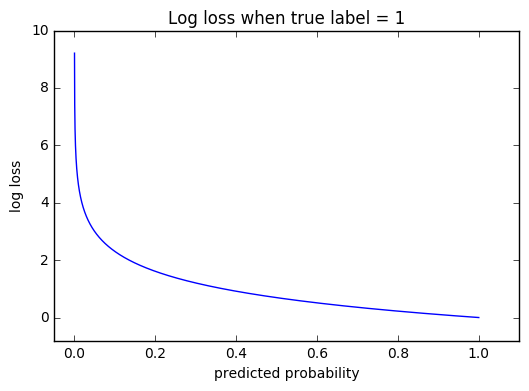

In [33]:
# visualize log loss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x,y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

In [26]:
?log_loss

So to play it safe, we round down our edge predictions, swap all ones with 0.95 and all zeros with .05

In [34]:
isdog = isdog.clip(min=0.05, max=0.95)

In [35]:
# extract image ids from filename in the test/unknown director
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [36]:
subm = np.stack([ids,isdog],axis=1)
subm[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   5.0000e-02],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [38]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/courses/deeplearning1/nbs/lesson1/data


In [39]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/'+submission_file_name)

/home/ubuntu/courses/deeplearning1/nbs/lesson1


/home/ubuntu/courses/deeplearning1/nbs/lesson1/data/submission1.csv